### Doesn't work

Error when training classifier model in fp16:

```
RuntimeError: output with type torch.cuda.HalfTensor doesn't match the desired type torch.cuda.FloatTensor
```

# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
from fastai.text import *
from fastai.version import __version__
print('fastai', __version__)

fastai 1.0.47


## The data set

The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

In [2]:
# path = untar_data(URLs.IMDB)
path = Path('/home/paperspace/.fastai/data/imdb')
path.ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/test'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/README'),
 PosixPath('/home/paperspace/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/paperspace/.fastai/data/imdb/unsup'),
 PosixPath('/home/paperspace/.fastai/data/imdb/models'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train')]

In [ ]:
train = path.ls()[-1]
train.ls()

In [ ]:
train.ls()

In [ ]:
test = path.ls()[2]
test.ls()

Dataset directory structure (training set):

Positive reviews are in `pos` folder. Each review is a text file.

Negative reviews are in `neg` folder. Each review is a text file.

Unlabeled reviews are in `unsup` folder. Each review is a text file.

### Language model data

[text.data docs](https://docs.fast.ai/text.data.html)

In [3]:
# Set batch size to 16 to avoid running out of GPU ram later
bs = 16

In [4]:
# Don't run these lines during practice. It'll take too long (4 minutes).
# Just run the next cell to load the data.
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train', 'test', 'unsup'])
          .split_by_rand_pct(valid_pct=0.1)
          .label_for_lm()
          .databunch(bs=bs))

In [ ]:
# Save
# data_lm.save('data_lm.pkl')

In [4]:
# Load language model data
data_lm = load_data(path, fname='data_lm.pkl', bs=16)

In [5]:
data_lm.show_batch()

idx,text
0,"with a narrator setting up every scene . xxmaj and boy does it drag . xxmaj scene after scene with nothing of any interest happening . xxmaj the special effects ( and i use the word "" special "" loosely ) consist of sock puppets . xxmaj yes , that 's right  sock puppets ! xxmaj the acting is abysmal . xxmaj angelika xxmaj jager is in the running"
1,"xxmaj the only ( deliberate ? ) grotesque in the piece was xxmaj gabriel , the brainwashed xxmaj presbyterian preacher played by xxmaj macfadyen , whose face is built in such a way as to suggest a permanent air of bewildered fury . xxmaj if i were kind , i would suggest that the xxmaj xxunk rantings of the preacher were a witty comment designed to make us despise xxmaj"
2,"this is not in the script , but we can forgive xxmaj miss xxmaj dressler 's excesses ; she is too good at it not to . xxmaj the story ends with a movement to the next thing , as distinct from resolution , which is n't the author 's cup of tea ; and those who like their films neatly worked out in the end will be disappointed by"
3,go . i do n't think it will disappoint and if your kids enjoyed the aquatic world brought to them by xxmaj pixar 's xxmaj finding xxmaj nemo i 'm sure they will love this too . i just wish all television was this entertaining . xxbos xxmaj opera ( the xxup u.s. title is terror at the opera ) is somewhat of a letdown after some of xxmaj dario
4,"look - alike xxmaj caviezel , and the great but short performance of xxmaj ron xxmaj perlman , it manages to be captivating . xxmaj we see far more swordplay than pulse rifle shoot - outs , so the sci - fi part of the film is largely suppressed to make way for the epic battle between the vikings and the xxunk , but that 's just how it must"


### Language model

In [5]:
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)
learn_lm.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj robot xxmaj holocaust is about the lamest , most pathetic attempt at making a post - apocalyptic movie that i 've seen . xxmaj and i thought the xxmaj italians were the masters of wretched xxmaj mad xxmaj max wannabes . xxmaj some of those movies like xxmaj escape 2000 are positively brilliant in comparison with this piece of poo . xxmaj the plot is nonsensical  even with a narrator setting up every scene . xxmaj and boy does it drag . xxmaj scene after scene with nothing of any interest happening . xxmaj the special effects ( and i use the word " special " loosely ) consist of sock puppets . xxmaj yes , that 's right  sock puppets ! xxmaj the acting is abysmal . xxmaj angelika xxmaj jager is in the running for worst performance i 've ever seen . xxmaj sure , she 's xxmaj french or xxmaj german or whatever  but man is she bad . i can not think of a single positive thing to say about the m

In [6]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


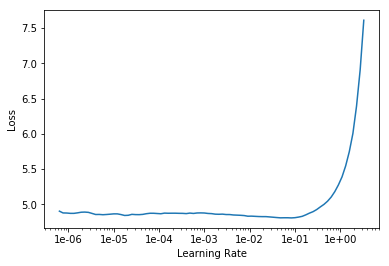

In [7]:
learn_lm.recorder.plot()

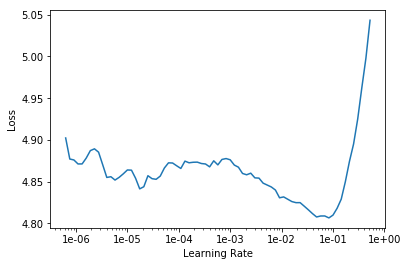

In [10]:
learn_lm.recorder.plot(skip_end=15)

In [11]:
lr = 1e-2
# momentum will be explained in a later lesson.
moms = (0.8, 0.7)

In [12]:
# Fit 1 cycle
# Don't execute during practice
learn_lm.fit_one_cycle(cyc_len=1, max_lr=lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,4.441909,4.296433,0.281376,1:17:12


In [13]:
# Save
learn_lm.save('lm-stage1-fp16')

In [10]:
# Load
learn_lm.load('lm-stage1-fp16')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj robot xxmaj holocaust is about the lamest , most pathetic attempt at making a post - apocalyptic movie that i 've seen . xxmaj and i thought the xxmaj italians were the masters of wretched xxmaj mad xxmaj max wannabes . xxmaj some of those movies like xxmaj escape 2000 are positively brilliant in comparison with this piece of poo . xxmaj the plot is nonsensical  even with a narrator setting up every scene . xxmaj and boy does it drag . xxmaj scene after scene with nothing of any interest happening . xxmaj the special effects ( and i use the word " special " loosely ) consist of sock puppets . xxmaj yes , that 's right  sock puppets ! xxmaj the acting is abysmal . xxmaj angelika xxmaj jager is in the running for worst performance i 've ever seen . xxmaj sure , she 's xxmaj french or xxmaj german or whatever  but man is she bad . i can not think of a single positive thing to say about the m

#### Finetune language model with our dataset

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


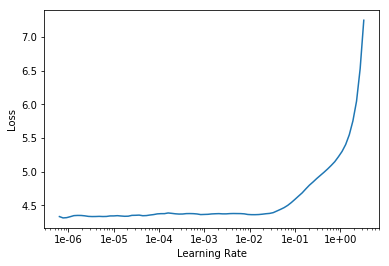

In [14]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [15]:
lr = 1e-3
moms = (0.8, 0.7)

#### Fit 1 cycle

In [17]:
# Don't execute during practice. Takes too long.
learn_lm.fit_one_cycle(cyc_len=1, max_lr=lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,3.998991,3.947896,0.320733,1:27:36


In [18]:
# Save
# learn_lm.save('lm-stage2-finetuned-fp16')

In [13]:
# learn_lm.save('lm-stage2-finetuned-fp16')
learn_lm.load('lm-stage2-finetuned-fp16')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj robot xxmaj holocaust is about the lamest , most pathetic attempt at making a post - apocalyptic movie that i 've seen . xxmaj and i thought the xxmaj italians were the masters of wretched xxmaj mad xxmaj max wannabes . xxmaj some of those movies like xxmaj escape 2000 are positively brilliant in comparison with this piece of poo . xxmaj the plot is nonsensical  even with a narrator setting up every scene . xxmaj and boy does it drag . xxmaj scene after scene with nothing of any interest happening . xxmaj the special effects ( and i use the word " special " loosely ) consist of sock puppets . xxmaj yes , that 's right  sock puppets ! xxmaj the acting is abysmal . xxmaj angelika xxmaj jager is in the running for worst performance i 've ever seen . xxmaj sure , she 's xxmaj french or xxmaj german or whatever  but man is she bad . i can not think of a single positive thing to say about the m

#### Export encoder: `lm-finetuned-encoder-fp32`

In [19]:
# Don't execute during practice
learn_lm.save_encoder('lm-finetuned-encoder-fp16')

#### Next word prediction

In [20]:
# Load the finetuned language model
# learn_lm = load_learner('lm-stage2-finetuned-fp32')

# Prediction args
TEXT = "I liked this movie because"
N_WORDS = 100
N_SENTENCES = 1

# Make predictions
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was indeed a very good movie . It 's one of the most interesting and entertaining films i have ever seen . i 've seen it twice in " The Flying Tall " and this is my favorite movie of all time . It was brilliant , and i think the one thing that made my eyes hit it off was the sound , and it 's definitely one of my favorite movies . i can relate to the characters in the movie and i know they 're not all around , because they


---

## Classifier: training data

This time, we'll create a databunch **with** labels.

In [ ]:
# Don't execute during practice
data = (TextList.from_folder(path, vocab=data_lm.vocab)
       .split_by_folder(valid='test')
       .label_from_folder(classes=['neg', 'pos'])
       .databunch(bs=16))

In [ ]:
# Save
# data.save('data_clas.pkl')

In [ ]:
# Load
data = load_data(path, fname='data_clas.pkl', bs=16)

In [27]:
data.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj perspective is a good thing . xxmaj since the release of "" xxmaj star xxmaj wars xxmaj episode i : xxmaj the xxmaj phantom xxmaj menace "" , claims and counter - claims of just how xxmaj episode 's xxup ii and xxup iii will eventuate has taken the spotlight off the ' original ' xxmaj star xxmaj wars films , making them part of a cohesive whole",pos
"xxbos xxmaj the effects of job related stress and the pressures born of a moral dilemma that pits conscience against the obligations of a family business ( albeit a unique one ) all brought to a head xxunk or perhaps the catalyst xxunk a midlife crisis , are examined in the dark and absorbing drama , ` xxmaj panic , ' written and directed by xxmaj henry xxmaj bromell ,",pos
"xxbos i have to admit that i went into xxmaj fever xxmaj pitch with low expectations . xxmaj it 's no huge revelation for me to say that xxmaj jimmy xxmaj fallon 's last movie ( xxmaj taxi ) was xxmaj xxunk bad , and the trailers for xxmaj fever xxmaj pitch were all right but did n't mesmerize me . i was already preparing some cheesy baseball puns for",pos
"xxbos xxmaj oftentimes , films of this nature come across as a mixed bag of great work along with slight drivel to fill the runtime . xxmaj whether it be the big name support or the project itself , xxmaj paris je t'aime never falls into this realm . i believe i can truly say that the movie as a whole is better than its parts . xxmaj between the",pos


## Classifier: create a model

Please restart the kernel.

In [2]:
# Restart the kernel and run these:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
from fastai.text import *

path = Path('/home/paperspace/.fastai/data/imdb')
data = load_data(path, fname='data_clas.pkl', bs=16)

In [3]:
data.batch_size

16

In [4]:
learn_clas = text_classifier_learner(data, arch=AWD_LSTM, drop_mult=0.5)
learn_clas.to_fp16()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [5]:
torch.cuda.memory_allocated()

111294464

#### Load encoder from language model

In [ ]:
# Save
# learn_clas.load_encoder('lm-finetuned-encoder-fp32')

In [6]:
# Load
learn_clas.load_encoder('lm-finetuned-encoder-fp16')

In [7]:
torch.cuda.memory_allocated()

224147456

#### Train the classifier

In [8]:
learn_clas.lr_find()
# learn_clas.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: output with type torch.cuda.HalfTensor doesn't match the desired type torch.cuda.FloatTensor

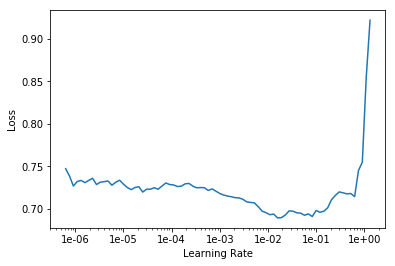

In [9]:
learn_clas.recorder.plot()

In [10]:
lr = 2e-2
moms = (0.8, 0.7)

In [ ]:
# Fit 1 cycle
# Don't execute during practice
learn_clas.fit_one_cycle(cyc_len=1, max_lr=lr, moms=moms)

In [ ]:
# Save
# learn_clas.save('clas-step-1')

In [11]:
# Load
learn_clas.load('clas-step-1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [12]:
torch.cuda.memory_allocated()

224655360

### Unfreeze layer by layer

#### Freeze all except the second last layer and the last layers

In [13]:
learn_clas.freeze_to(n=-2)

In [14]:
lr = slice(5e-3/(2.6**4),5e-3) # We'll learn more about this later

In [ ]:
# Don't execute during practice
# Fit 1 cycle
learn_clas.fit_one_cycle(cyc_len=1, max_lr=lr, moms)

In [ ]:
# Save
# learn_clas.save('clas-step-2')

In [16]:
# Load
learn_clas.load('clas-step-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [17]:
torch.cuda.memory_allocated()

245260288

#### Freeze all except the third last layer and the last layers

In [18]:
learn_clas.freeze_to(n=-1)

In [19]:
lr = slice(5e-3/(2.6**4),5e-3) # We'll learn more about this later

In [ ]:
# Don't execute during practice
learn_clas.fit_one_cycle(cyc_len=1, max_lr=lr, moms)

In [ ]:
# Save
# learn_clas.save('clas-stage-3')

In [20]:
# Load
learn_clas.load('clas-stage-3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [21]:
torch.cuda.memory_allocated()

224149504

#### Unfreeze all layers

At this point, it's a good idea to restart the kernel and load the model from file to avoid running out of GPU memory.

In [1]:
# Restart and run these:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
from fastai.text import *

path = Path('/home/paperspace/.fastai/data/imdb')
data = load_data(path, fname='data_clas.pkl', bs=16)
learn_clas = text_classifier_learner(data, arch=AWD_LSTM, drop_mult=0.5)
learn_clas.load('clas-stage-3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [2]:
learn_clas.unfreeze()

In [3]:
lr = slice(1e-3/(2.6**4),1e-3)
moms = (0.8, 0.7)

In [ ]:
# Fit two cycles
# Don't execute during practice
learn_clas.fit_one_cycle(cyc_len=2, max_lr=lr, moms)

In [ ]:
# Save
# learn_clas.save('clas-stage-4')

In [4]:
# Load
learn_clas.load('clas-stage-4')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

In [10]:
torch.cuda.memory_allocated()

659079680

### Make predictions

In [9]:
learn_clas.predict('What an awful movie!')

(Category neg, tensor(0), tensor([0.9663, 0.0337]))

In [26]:
learn_clas.predict('worst film ever!')
# wat

(Category pos, tensor(1), tensor([0.0564, 0.9436]))